# HW-4 - Evaluation
In this homework, we will use the Car price dataset. Download it from here:

https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

We'll keep working with the `MSRP` variable, and we'll transform it to a classification task.

## 1. Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

## 2. Import dataset

For the rest of the homework, you'll need to use only these columns:

`[Make, Model, Year, Engine HP, Engine Cylinders, Transmission Type, Vehicle Style, highway MPG, city mpg, MSRP]`

### Data Preparation

- Keep only the columns above.

In [2]:
cols = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type",
        "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(url, usecols=cols)

- Lowercase the column names and replace spaces with underscores.

In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

- Fill the missing values with **0**.

In [4]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [5]:
df["engine_hp"].fillna(value=0, inplace=True)
df["engine_cylinders"].fillna(value=0, inplace=True)

- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`.

In [6]:
df.rename(columns = {'msrp':'price'}, inplace = True)

In [7]:
mean = df["price"].mean()
df["above_average"] = np.where(df["price"]>=mean, 1, 0)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [8]:
dff = df.copy()
df = df.drop("price", axis=1)

- Split the data into 3 parts: train/validation/test with 60% / 20% / 20% distribution. Use `train_test_split` function for that with `random_state=1`.

In [9]:
dff_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(dff_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["above_average"]
y_val = df_val["above_average"]
y_test = df_test["above_average"]

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:
- For each numerical variable, use it as score and compute AUC with the `above_average` variable.
- Use the **training** dataset for that.

If your AUC is < 0.5, invert this variable by putting "**-**" in front:

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable — then negative correlation becomes positive.

Which numerical variable (among the following 4) has the **highest** AUC? \
<u>**`engine_hp`**</u> \
`engine_cylinders` \
`highway_mpg` \
`city_mpg`


In [10]:
# Numerical varaibles
num_cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [11]:
for col in num_cols:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'{col}: auc={round(auc,3)}')

engine_hp: auc=0.917
engine_cylinders: auc=0.766
highway_mpg: auc=0.633
city_mpg: auc=0.673


- Which numerical variable has the **highest** AUC? = **`engine_hp`**

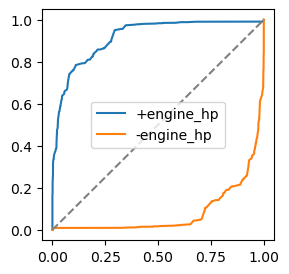

In [12]:
# Plotting the ROC curve
plt.figure(figsize=(3, 3))

fpr, tpr, _ = roc_curve(y_train, df_train["engine_hp"])
plt.plot(fpr, tpr, label='+engine_hp')

fpr, tpr, _ = roc_curve(y_train, -df_train["engine_hp"])
plt.plot(fpr, tpr, label='-engine_hp')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

## Question 2: Training the model

Apply **one-hot-encoding** using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the **AUC** of this model on the **validation** dataset? (round to 3 digits) \
`0.678` \
`0.779` \
`0.878` \
<u>**`0.979`**</u>

In [13]:
all_cols = df_train.columns.to_list()
all_cols

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [14]:
# Dictionary for the df_train set
train_dicts = df_train[all_cols].to_dict(orient='records')

# Apply One-hot encoding to X_train
dv = DictVectorizer(sparse=False)
df_train_oh = dv.fit_transform(train_dicts)

In [15]:
# Instantiate and Fit the Model over X_train_oh
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_train_oh, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
# Apply One-hot encoding to X_val
val_dicts = df_val[all_cols].to_dict(orient='records')
df_val_oh = dv.transform(val_dicts)

# Predict Values with 'model' on X_val_oh
y_pred = model.predict_proba(df_val_oh)[:, 1]

In [17]:
# ROC AUC score:
roc = roc_auc_score(y_val, y_pred)
round(roc,3)

0.979

- What's the **AUC** of this model on the **validation** dataset? (round to 3 digits) = **`0.979`**

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from **0.0** to **1.0** with step **0.01**
- For each threshold, compute **precision** and **recall**
- Plot them

At which threshold precision and recall curves intersect? \
`0.28` \
<u>**`0.48`**</u> \
`0.68` \
`0.88`

In [18]:
# Creating Confusion Matrix:
def confusion_matrix_df(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


# Use of the functions
df_scores = confusion_matrix_df(y_val, y_pred)
df_scores[::10]     

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,334,10,1395
20,0.2,623,201,31,1528
30,0.3,606,144,48,1585
40,0.4,590,106,64,1623
50,0.5,570,73,84,1656
60,0.6,550,51,104,1678
70,0.7,506,30,148,1699
80,0.8,464,21,190,1708
90,0.9,376,3,278,1726


In [19]:
# Add column 'p' (precision) and 'r' (recall)
df_scores["p"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["r"] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [20]:
# Filter df_scores by the difference between 'p' & 'r'
df_scores[abs(df_scores["p"] - df_scores["r"]) < 0.01]

,threshold,tp,fp,fn,tn,p,r
46,0.46,577,84,77,1645,0.872920,0.882263
47,0.47,575,81,79,1648,0.876524,0.879205
48,0.48,571,81,83,1648,0.875767,0.873089
49,0.49,571,80,83,1649,0.877112,0.873089


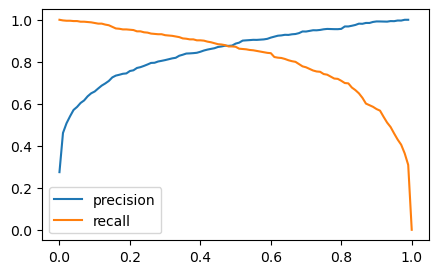

In [21]:
# Plot the curves
plt.figure(figsize=(5, 3))

plt.plot(df_scores["threshold"], df_scores["p"], label='precision')
plt.plot(df_scores["threshold"], df_scores["r"], label='recall')

plt.legend()
plt.show()

- At which threshold precision and recall curves intersect? = **`0.48`**

## Question 4: F1 score

Precision and recall are conflicting — when one grows, the other goes down. That's why they are often combined into the F1 score — a metrics that takes into account both.

This is the formula for computing F1:

$$ F_1 = 2 \cdot \cfrac{P \cdot R}{P + R} $$

Where $P$ is precision and $R$ is recall.

Let's compute **F1** for all thresholds from **0.0** to **1.0** with increment **0.01**

At which threshold **F1** is **maximal**? \
`0.12` \
`0.32` \
<u>**`0.52`**</u> \
`0.72`

In [22]:
# Calculate F1 scores
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

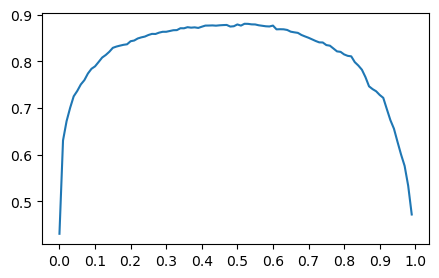

In [23]:
# Plot F1 score
plt.figure(figsize=(5,3))
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [24]:
df_scores.sort_values(by="f1",ascending=False).head()

,threshold,tp,fp,fn,tn,p,r,f1
52,0.52,563,62,91,1667,0.900800,0.860856,0.880375
53,0.53,562,61,92,1668,0.902087,0.859327,0.880188
54,0.54,560,60,94,1669,0.903226,0.856269,0.879121
50,0.50,570,73,84,1656,0.886470,0.871560,0.878951
55,0.55,559,59,95,1670,0.904531,0.854740,0.878931


- At which threshold **F1** is **maximal**? = `0.52`

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds? \
<u>**`0.003`**</u> \
`0.030` \
`0.090` \
`0.140`

In [25]:
def train(df_train, y_train, C=1.0):
    train_dicts = df_train[all_cols].to_dict(orient='records')

    dv_kf = DictVectorizer(sparse=False)
    X_train = dv_kf.fit_transform(train_dicts)

    model_kf = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model_kf.fit(X_train, y_train)

    return dv_kf, model_kf

def predict(df, dv, model):
    pred_dicts = df[all_cols].to_dict(orient='records')

    X = dv.transform(pred_dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [26]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(dff_train):
    df_train_kf = dff_train.iloc[train_idx]
    df_val_kf = dff_train.iloc[val_idx]

    y_train_kf = df_train_kf["above_average"]
    y_val_kf = df_val_kf["above_average"]

    dv_kf, model_kf = train(df_train_kf, y_train_kf, C=1.0)
    y_pred_kf = predict(df_val_kf, dv_kf, model_kf)

    auc_sc = roc_auc_score(y_val_kf, y_pred_kf)
    scores.append(auc_sc)

print(f'auc={round(np.mean(scores),4)}, std={round(np.std(scores),4)}')

auc=0.9802, std=0.0025


- How large is standard devidation of the scores across different folds? = **`0.003`**

## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`:

- Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
- Initialize `KFold` with the same parameters as previously
- Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the **mean** score as well as the **std** (round the **mean** and **std** to 3 decimal digits)

Which `C` leads to the **best mean score**? \
`0.01` \
`0.1` \
`0.5` \
<u>**`10`**</u>

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [27]:
# KFold with differnte values for C
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(dff_train):
        df_train = dff_train.iloc[train_idx]
        df_val = dff_train.iloc[val_idx]

        y_train = df_train["above_average"]
        y_val = df_val["above_average"]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc_sc = roc_auc_score(y_val, y_pred)
        scores.append(auc_sc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C=   1, 0.980 +- 0.002
C=  10, 0.981 +- 0.002


- Which `C` leads to the **best mean score**? = <u>**`10`**</u>